<h1><center>Using <font color=purple>Qiskit</font> to Build Quantum Circuits</center></h1>

<h4><center> Nuno Marques, Physics of Classical and Quantum Information, 2022/23 </center></h4>

<h5><center> Instituto Superior Técnico, Universidade de Lisboa, 10/1/2023 </center></h5>

## What is <font color=purple>Qiskit?</font>

- Qiskit is an open-source software development kit that allows you to simulate circuits and algorithms using Python.

- Can test your circuits on real devices.

- It is best used in combination with Jupyter Notebooks!


## Initialization

- Initialize a circuit by calling the function `QuantumCircuit(n,k)`; `n` is the number of qubits and `k` is the number of bits.
- By default each qubit is set to $0$.
- Set the qubits by labelling with a string (e.g `001`) or by using a list separated by commas. The values in this list are the scalars for the basis vectors. Be mindful of $littleEndian$!

- Example for a three-qubit system: $|000⟩$ $|001⟩$ $|010⟩$ $|011⟩$ $|100⟩$ $|101⟩$ $|110⟩$ $|111⟩$

In [225]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

qc = QuantumCircuit(3)

qc.initialize([1, 0, 0, 0, 0, 0, 0, 0], qc.qubits)

st0 = Statevector(qc)
st0.draw(output='latex')

<IPython.core.display.Latex object>

In [226]:
qc.initialize('000', qc.qubits)
st0 = Statevector(qc)
st0.draw(output='latex')


<IPython.core.display.Latex object>

## Adding Gates

<div style="text-align: justify">Now that we know how to initialize our state we want to know how to add some gates.

This is actually very easy since it is just calling a `method` to the circuit `object`!

The basic syntax goes like this: `qc.GATE(control_qubit1: QubitSpecifier, ..., target_qubit: QubitSpecifier)`. It is also important to know that we should add the gates from the left to the right.

Let's try to make a very simple circuit consisting of three qubits and five gates. Two <b>X</b> gates acting on the first two qubits, followed by a <b>CCZ</b> gate controlled by these qubits and acting on the third and, again, two <b>X</b> gates acting on the first two qubits.

This is actually the $Flip Operator$ from PSET9!</div>

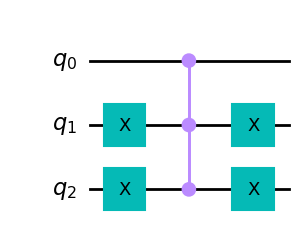

In [227]:
qc = QuantumCircuit(3)

qc.x(1)

qc.x(2)

qc.ccz(1, 2, 0)

qc.x(1)

qc.x(2)

qc.draw('mpl')


## Evolution

We can see what the circuit does to our initial state using the `evolve` method.

In [228]:
state = Statevector.from_label('001')

state.evolve(qc).draw(output='latex')


<IPython.core.display.Latex object>

## Measurement

We move on to a more complex task. In PSET8 there is a circuit that allows us to measure the overlap between some arbitrary states  $|\alpha⟩$ and $|\beta⟩$.

To test this we start initializing these qubits as random states (`random_statevector` method) and passing them through the circuit.

Afterwards, we construct an histogram by measuring the results of the experiment many times using the `Aer` simulator.

Then we are able to actually compute the overlap!

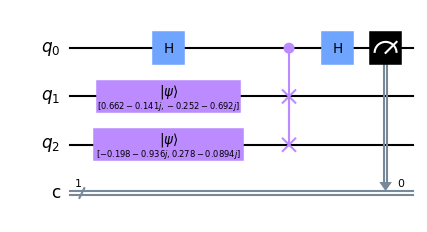

In [229]:
from qiskit.quantum_info import random_statevector

qc = QuantumCircuit(3, 1)

state_a = random_statevector(2)
state_b = random_statevector(2)

actual_prob = 0.5 * (1 + np.abs((state_a.inner(state_b))) ** 2)

qc.initialize(state_a, 1), qc.initialize(state_b, 2), qc.h(0), qc.cswap(0, 1, 2), qc.h(0)

qc.measure(0, 0)

qc.draw('mpl', scale = 0.75)


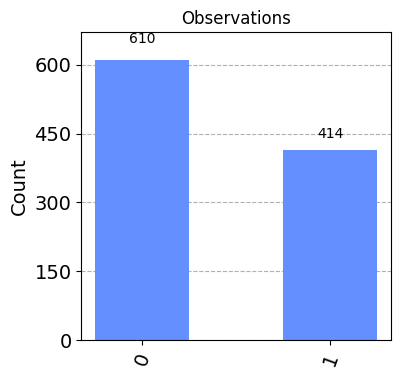

In [230]:
from qiskit import Aer, transpile, assemble
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)
result = simulator.run(qc).result()
counts = result.get_counts(qc)

plot_histogram(counts, title='Observations', figsize=(4, 4))


In [231]:
measured_prob = counts.get('0') / (counts.get('0') + counts.get('1'))

print("Actual prob: " + str(actual_prob) + ", Measured prob: " +
      str(measured_prob) + ", Difference: " + str(np.abs(actual_prob-measured_prob)))


Actual prob: 0.5935206935377986, Measured prob: 0.595703125, Difference: 0.0021824314622014285


## Making Deutsch-Jozsa

The first step in implementing this algorithm is creating a function that generates random Oracles.

In order to do this we first notice that the the Oracle leaves the system in the state: $\frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2n-1} (-1)^{f(x)}|x⟩ $.

If the Oracle is constant then it can be considered to either be the identity matrix $I$ or the diagonal matrix where all of it's elements are $-1$.

If the Oracle is balanced then it can be viewed as a diagonal matrix where half of its elements are chosen randomly to be $-1$ and the rest $1$!

In [232]:
import random as rand

def dj_oracle(n):
    '''
    Input: the registry size n
    Output: Random unitary matrix U and a string

    The function is chosen randomly to be constant or balanced.
    If its balanced it can either be f(x)=0 or f(x)=1.
    If its balanced we choose N / 2 elements without replacement

    When f(x)=1 we multiply U by -1
    When its balanced we multiply the chosen indexes by -1
    '''

    N = 2 ** n

    indexes = list(np.arange(N))

    U = np.identity(N)

    type = rand.choice(["constant", "balanced"])

    if type == "constant":

        type = rand.choice(["f(x)=0", "f(x)=1"])

        if type == "f(x)=1":

            U = U * -1

    if type == "balanced":

        for i in range(int(N/2)):
            ind = rand.choice(indexes)
            U[ind][ind] = -1
            indexes.remove(ind)

    return U, type

Then we can actually implement the algorithm.

To do this we simply copy the steps from the original algorithm. 

Note: Since our return type is a `np.array` we use the `unitary` method to add the oracle to the circuit.

In [233]:
def dj_algorithm(oracle):
    '''
    Input: The Oracle
    Output: O circuito quântico dj

    '''

    n = int(np.log2(np.size(oracle[0])))

    dj = QuantumCircuit(n + 1, n)

    # Hadamard nos bits input
    for i in range(n):
        dj.h(i)

    # |0> -> |1> -> |->
    dj.x(n)
    dj.h(n)

    # Oráculo
    dj.unitary(oracle, range(n))

    for i in range(n):
        dj.h(i)

    for i in range(n):
        dj.measure(i, i)

    return dj


Now we can finally simulate the algorithm using the techniques learned previously!

f(x)=1


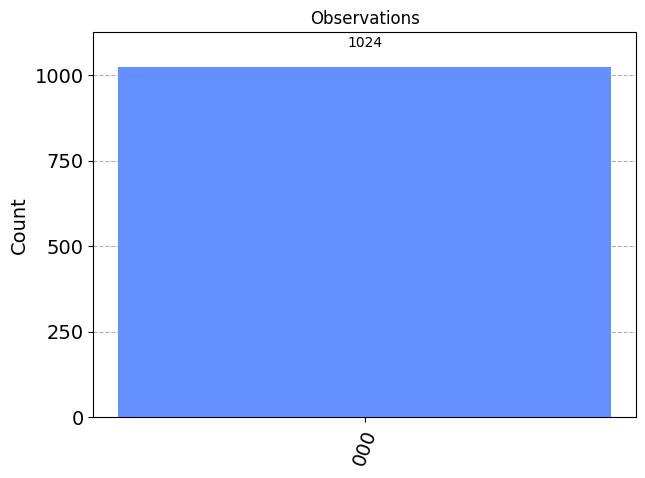

In [234]:
U, type = dj_oracle(3)
print(type)
dj = dj_algorithm(U)

circ = transpile(dj, simulator)
result = simulator.run(circ, shots=1024).result()
counts = result.get_counts(circ)

plot_histogram(counts, title='Observations')

# Making Grover's

As was previously done, we need to start by constructing a random Oracle.

In the original problem we can know a priori the number of solutions. If we don't know then we choose a random number between $1$ and $N$.

Also if the solution is not known it is useful to consider a list of size $2N$ instead of $N$, since the solutions might make up most of our list. We apply the same strategy if the solution is known and takes up half or more of the list.

Then we generate $M$ random indexes ranging from $0$ to $N-1$. These indexes will be the indexes of our solutions.

We then take the identity matrix $I$ and multiply the elements corresponding to these indexes by $-1$, since the operation of the Oracle acting on our system is $|x⟩ \to (-1)^{f(x)}|x⟩$. ($(-1)^{f(x)}=-1$ if $x$ is solution)!

In [235]:
def g_oracle(N, M='r'):
    '''
    Input: Size of the list and number of solutions if known.
    Output: The Oracle and the ideal number of iterations.

    '''

    solutions = []

    if M == 'r':
        M = rand.randint(1, N)
        N = 2 * N

    elif M >= N / 2:
        N = 2 * N

    n = int(np.ceil(np.log2(N)))

    indexes = list(range(N))

    # M random solutions
    for i in range(M):
        ind = rand.choice(indexes)
        solutions.append(ind)
        indexes.remove(ind)

    bin_sol = []
    for sol in solutions:
        bin_sol.append('{0:b}'.format(sol))
    print(np.sort(bin_sol))

    U = np.identity(2 ** n)
    for ind in solutions:
        U[ind][ind] = U[ind][ind] * -1

    iter = int(np.floor((np.pi / 4) * np.sqrt(N/M)))

    return U, iter

The next logical step is to make the grover's iterator $G$. This is very simply done!.

In fact, we only need to look at the expression $G = (2|s⟩⟨s| − I)O$, where $s$ is the uniform superposition of states and O is our oracle.

We also introduce another useful method, the `to_gate` method, to cast this `np.array object` to `gate object`

In [236]:
def G(n, oracle):

    qc = QuantumCircuit(n)

    dim = 2 ** n

    uni_sup = np.ones((1, dim)) * (1 / (np.sqrt(dim)))

    G = np.matmul((2 * np.kron(np.transpose(uni_sup),
                  uni_sup) - np.identity(dim)), oracle)

    qc.unitary(G, range(n))

    G_gate = qc.to_gate()
    G_gate.name = "G"

    return G_gate


Lastly, we implement the algorithm by following the steps of the original and run a couple of simulations!

In [237]:
def grover(oracle):

    n = int(np.log2(np.size(oracle[0])))

    qc = QuantumCircuit(n)

    for qubit in range(n):
        qc.h(qubit)

    for i in range(ITER):
        qc.append(G(n, oracle), range(n))

    qc.measure_all()
    return qc


['1' '10' '11']


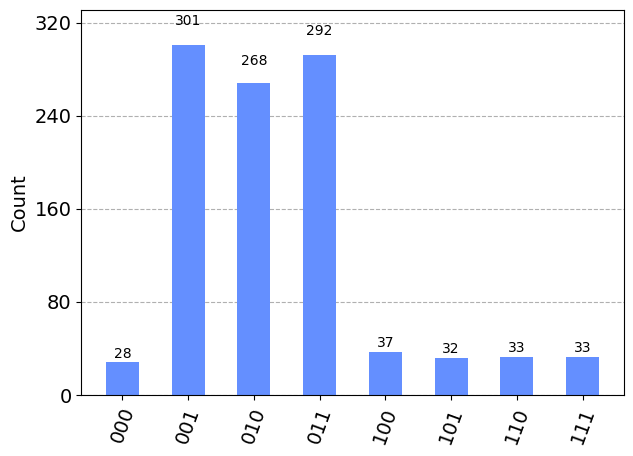

In [240]:
oracle, ITER = g_oracle(4, 3)
grover_qc = grover(oracle)

transpiled_grover_circuit = transpile(grover_qc, simulator)
results = simulator.run(transpiled_grover_circuit, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)


## Using Real Devices

We can run our circuit in real devices. For that we need to get a `provider`, a `device` and a `backend`. Some parameters might need tuning according to the circuit we are trying to simulate.

If you want to simulate it yourself you will need to create an IBM account.

This will not be done live sadly because it takes time!

In [244]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

N = 3

oracle, ITER = g_oracle(3)
grover_qc = grover(oracle)

size = np.ceil(np.log2(N))

IBMQ.load_account()

provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends
(filters=lambda x: int(x.configuration().n_qubits) >= size and 
not x.configuration().simulator and x.status().operational==True))

backend = least_busy(provider.backends
(filters=lambda x: int(x.configuration().n_qubits) >= size and 
not x.configuration().simulator and x.status().operational==True))

['0' '1' '100']


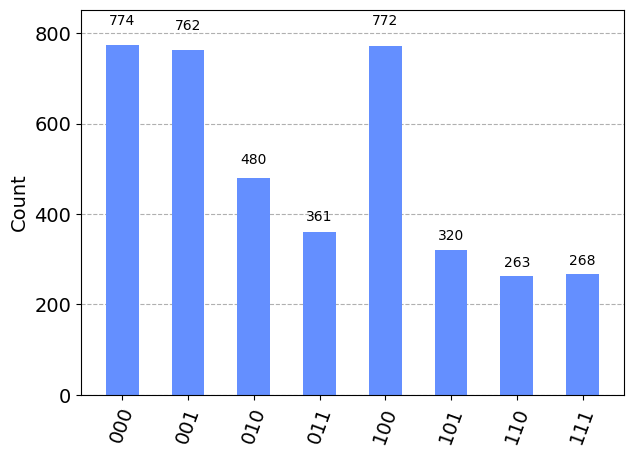

In [246]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_qc, 
device, optimization_level=1)

job = device.run(transpiled_grover_circuit)

# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_qc)
plot_histogram(answer)
